This project pulls data from Google BigQuery to analyze the chicago_taxi_trips.taxi_trips database and predicts if a customer will tip. 

About the data:
* unique_key	- Unique identifier for the trip.	
* taxi_id	- A unique identifier for the taxi.	
* trip_start_timestamp	- When the trip started, rounded to the nearest 15 minutes.	
* trip_end_timestamp	- When the trip ended, rounded to the nearest 15 minutes.	
* trip_seconds	- Time of the trip in seconds.	
* trip_miles	- Distance of the trip in miles.	
* pickup_census_tract	- The Census Tract where the trip began.	
* dropoff_census_tract	- The Census Tract where the trip ended. 	
* pickup_community_area	- The Community Area where the trip began.	
* dropoff_community_area	- The Community Area where the trip ended.	
* fare	- The fare for the trip.	
* tips - The tip for the trip. Cash tips generally will not be recorded.	
* tolls The tolls for the trip.	
* extras - Extra charges for the trip.	
* trip_total - Total cost of the trip, the total of the fare, tips, tolls, and extras.	
* payment_type - Type of payment for the trip.	
* company - The taxi company.	
* pickup_latitude - The latitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.	
* pickup_longitude - The longitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.	
* pickup_location - The location of the center of the pickup census tract or the community area if the census tract has been hidden for privacy.	
* dropoff_latitude - The latitude of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.	
* dropoff_longitude - The longitude of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.	
* dropoff_location - The location of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy.

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
%load_ext google.colab.data_table

In [3]:
project_id = 'sixth-flag-316719'

In [4]:
from google.cloud import bigquery
 
client = bigquery.Client(project=project_id)

In [5]:
# Return the first 10 rows
 
first_ten = client.query('''
SELECT *
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
LIMIT 10''').to_dataframe()

In [6]:
first_ten

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,bbb3bba9b81ea126d325d90ef4d7fa0dec436728,7602478d4ed02f3137d6f55c94cc89d74735b5482ec7d0...,2015-09-04 05:00:00+00:00,2015-09-04 05:00:00+00:00,0,0.0,None,None,None,None,45.00,0.00,0.0,0.0,45.00,Credit Card,Suburban Dispatch LLC,None,None,None,None,None,None
1,4bc6eb36fe379d8a1f7755627cb5b406cdebc3fb,bae6078388ab7627f76e217a321368a76965cf158936bc...,2014-12-25 20:00:00+00:00,2014-12-25 20:00:00+00:00,0,0.0,None,None,None,None,28.40,5.00,0.0,0.0,33.40,Credit Card,Suburban Dispatch LLC,None,None,None,None,None,None
2,60299e81ed704dd3ca42409af0aae4a8888074f8,a6c3cb7ab4c037a7db9e2fd3513f28e0ff17c8547a70bd...,2014-12-02 21:30:00+00:00,2014-12-02 22:00:00+00:00,1620,15.4,None,None,None,None,32.65,10.70,2.0,19.0,64.35,Credit Card,Dispatch Taxi Affiliation,None,None,None,None,None,None
3,df9262e58edf5fc423829122ebd3292a4e420280,014a6a87df1b7d2d56199cb980bb71c16a2bcee38238b1...,2014-11-29 14:45:00+00:00,2014-11-29 14:45:00+00:00,0,0.0,None,None,None,None,7.85,1.57,0.0,0.0,9.42,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
4,6b849e3a75af64f9dbba8f9b4d7912f82b6e399d,d31d372d2b930acc658e9b72ba4fd17b08ab09ee936051...,2014-12-28 01:45:00+00:00,2014-12-28 01:45:00+00:00,300,0.6,None,None,None,None,5.05,0.00,0.0,1.0,6.05,Cash,Taxi Affiliation Services,None,None,None,None,None,None
5,0d93d5489b7bb1ddc6521a82818952b03959520e,9e923176b8dde7f338d9aeb93b1c45d198ddf767ac6985...,2014-12-21 14:45:00+00:00,2014-12-21 14:45:00+00:00,0,0.0,None,None,None,None,4.05,0.81,0.0,0.0,4.86,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
6,750b3be4f0487be6b2a375d6fa5a07a81abc9b98,39c9a1f260ac7be5e06609b127219dacc45babf6e22f5e...,2014-11-29 14:45:00+00:00,2014-11-29 14:45:00+00:00,0,0.0,None,None,None,None,6.85,2.06,0.0,0.0,8.91,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
7,fa599bc63f49e95ed1df55121c5c789586261235,07f2bd961ac4c9e067abf0b0e4074aec9d6507f7d0373a...,2015-01-18 03:00:00+00:00,2015-01-18 03:00:00+00:00,0,0.0,None,None,None,None,7.45,1.86,0.0,0.0,9.31,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
8,d34b66089292d704908263c5ca010056a4d01715,dceced991ad06ec236c6f009fcf4aaeed3d5aaf38c45d2...,2015-01-18 13:30:00+00:00,2015-01-18 13:30:00+00:00,0,0.0,None,None,None,None,7.85,2.00,0.0,0.0,9.85,Credit Card,T.A.S. - Payment Only,None,None,None,None,None,None
9,4fbde41ee5e0902d5452ab1fcbb3f0ab8e393bbe,eecaba329d22b57acd34be5c5604891308b1c4d0f95f06...,2014-12-21 05:00:00+00:00,2014-12-21 05:00:00+00:00,0,0.0,None,None,None,None,8.15,1.63,0.0,0.0,9.78,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None


In [7]:
# Return the timeframe of the data
 
time_window = client.query('''
SELECT MIN(trip_start_timestamp),  MAX(trip_start_timestamp)
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`''').to_dataframe()

In [8]:
time_window

,f0_,f1_
0,2013-01-01 00:00:00+00:00,2021-10-01 00:00:00+00:00


In [9]:
# Return the number of null tips
 
empty_tip = client.query('''
SELECT COUNT(*)
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
  tips IS NULL;''').to_dataframe()

In [10]:
empty_tip

,f0_
0,5103


In [11]:
# Create a sampled dataframe for training; dates are year 2018
 
sample_count = 75000
row_count = client.query('''
  SELECT
    COUNT(*) as total
  FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`''').to_dataframe().total[0]
 
training_table = client.query('''
SELECT *
    FROM
          `bigquery-public-data.chicago_taxi_trips.taxi_trips`
    WHERE
           tips IS NOT NULL AND
           trip_seconds IS NOT NULL AND
           trip_miles IS NOT NULL AND
           fare IS NOT NULL AND
           tolls IS NOT NULL AND
           pickup_community_area IS NOT NULL AND
           dropoff_community_area IS NOT NULL AND
           trip_miles > 1 AND # Trips longer than 1 mile
           trip_seconds > 180 AND # Duration longer than 3 minutes
           EXTRACT (YEAR FROM trip_start_timestamp) = 2018
           AND RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()
 
print('Full dataset has %d rows' % row_count)

Full dataset has 197421650 rows


In [13]:
training_table.head()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,4b5bd412aa91f8470e054f8dba05acc1ecf375a4,f1c65a0964d6809ab9e54cc34e2644a1765f681cce2948...,2018-10-04 18:15:00+00:00,2018-10-04 18:30:00+00:00,1020,3.1,1.703106e+10,1.703108e+10,6,8,12.25,0.0,0.0,0.0,12.25,Cash,KOAM Taxi Association,41.934762,-87.639854,POINT (-87.6398538587 41.9347624564),41.893216,-87.637844,POINT (-87.6378442095 41.8932163595)
1,679835c07b3999bb9c9ee4775aa18718d22b2ef2,89a40bbeb44e22e8169b4ba823c5eee94b324219fbe8c0...,2018-10-03 23:45:00+00:00,2018-10-03 23:45:00+00:00,300,1.2,NaN,NaN,16,15,6.50,0.0,0.0,0.0,6.50,Cash,Taxi Affiliation Services,41.953582,-87.723452,POINT (-87.7234523905 41.9535821253),41.954028,-87.763399,POINT (-87.7633990316 41.9540276487)
2,bba0c69f7e87eff8be87c6bdbce78ee6cf1b9aec,46ea12565cc6105b04e553ab59d40197c6d3e0c4e9d71d...,2018-11-03 23:30:00+00:00,2018-11-04 00:00:00+00:00,1440,8.2,1.703103e+10,1.703128e+10,3,28,24.00,4.8,0.0,0.0,28.80,Credit Card,Star North Management LLC,41.972668,-87.663865,POINT (-87.6638654956 41.9726679555),41.885300,-87.642808,POINT (-87.6428084655 41.8853000224)
3,37580dda400377ab110a2926534f78d7a06e94b1,b6f9cd094b02ffe9e01b73fec81f2be157d917ec8354b0...,2018-11-18 19:30:00+00:00,2018-11-18 19:45:00+00:00,360,1.7,NaN,NaN,4,5,7.50,0.0,0.0,0.0,7.50,Cash,Taxi Affiliation Services,41.975171,-87.687516,POINT (-87.68751551520002 41.9751709433),41.947792,-87.683835,POINT (-87.6838349425 41.9477915865)
4,f7b8afd52d1c529b4028c7ddd5b85347ea190675,46ea12565cc6105b04e553ab59d40197c6d3e0c4e9d71d...,2018-11-12 22:30:00+00:00,2018-11-12 22:45:00+00:00,900,3.9,NaN,NaN,14,23,13.25,0.0,0.0,0.0,13.25,Cash,Star North Management LLC,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.900070,-87.720918,POINT (-87.7209182385 41.9000696026)


In [14]:
training_table['company'].nunique() # too many dummy variables

37

# Clean the Data

In [15]:
# drop unnecessary features; we'll use pickup and dropoff community areas instead of locations
 
training_table = training_table.drop(['unique_key', 'taxi_id', 'pickup_location', 'dropoff_location', 'pickup_census_tract', 'dropoff_census_tract', 'company'], axis=1)

In [16]:
training_table.head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2018-10-04 18:15:00+00:00,2018-10-04 18:30:00+00:00,1020,3.1,6,8,12.25,0.0,0.0,0.0,12.25,Cash,41.934762,-87.639854,41.893216,-87.637844
1,2018-10-03 23:45:00+00:00,2018-10-03 23:45:00+00:00,300,1.2,16,15,6.50,0.0,0.0,0.0,6.50,Cash,41.953582,-87.723452,41.954028,-87.763399
2,2018-11-03 23:30:00+00:00,2018-11-04 00:00:00+00:00,1440,8.2,3,28,24.00,4.8,0.0,0.0,28.80,Credit Card,41.972668,-87.663865,41.885300,-87.642808
3,2018-11-18 19:30:00+00:00,2018-11-18 19:45:00+00:00,360,1.7,4,5,7.50,0.0,0.0,0.0,7.50,Cash,41.975171,-87.687516,41.947792,-87.683835
4,2018-11-12 22:30:00+00:00,2018-11-12 22:45:00+00:00,900,3.9,14,23,13.25,0.0,0.0,0.0,13.25,Cash,41.968069,-87.721559,41.900070,-87.720918


In [17]:
# Pre-process dates and time
 
training_table['Month'] = training_table['trip_start_timestamp'].apply(lambda time: time.month)
training_table['Day of Week'] = training_table['trip_start_timestamp'].apply( lambda time: time.dayofweek)
training_table['Hour'] = training_table['trip_start_timestamp'].apply(lambda time: time.hour)

In [18]:
# data now consists of month, day of week, and hour
 
training_table.head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,Month,Day of Week,Hour
0,2018-10-04 18:15:00+00:00,2018-10-04 18:30:00+00:00,1020,3.1,6,8,12.25,0.0,0.0,0.0,12.25,Cash,41.934762,-87.639854,41.893216,-87.637844,10,3,18
1,2018-10-03 23:45:00+00:00,2018-10-03 23:45:00+00:00,300,1.2,16,15,6.50,0.0,0.0,0.0,6.50,Cash,41.953582,-87.723452,41.954028,-87.763399,10,2,23
2,2018-11-03 23:30:00+00:00,2018-11-04 00:00:00+00:00,1440,8.2,3,28,24.00,4.8,0.0,0.0,28.80,Credit Card,41.972668,-87.663865,41.885300,-87.642808,11,5,23
3,2018-11-18 19:30:00+00:00,2018-11-18 19:45:00+00:00,360,1.7,4,5,7.50,0.0,0.0,0.0,7.50,Cash,41.975171,-87.687516,41.947792,-87.683835,11,6,19
4,2018-11-12 22:30:00+00:00,2018-11-12 22:45:00+00:00,900,3.9,14,23,13.25,0.0,0.0,0.0,13.25,Cash,41.968069,-87.721559,41.900070,-87.720918,11,0,22


In [19]:
# Since the data consists of starting hour and duration, start and end time stamps can be dropped
 
training_table = training_table.drop(['trip_start_timestamp', 'trip_end_timestamp'], axis=1)

In [20]:
# Since we have pickup and dropoff communities we shouldn't need longitudes or latitudes
 
training_table = training_table.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1)

In [21]:
training_table.head()

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,Month,Day of Week,Hour
0,1020,3.1,6,8,12.25,0.0,0.0,0.0,12.25,Cash,10,3,18
1,300,1.2,16,15,6.50,0.0,0.0,0.0,6.50,Cash,10,2,23
2,1440,8.2,3,28,24.00,4.8,0.0,0.0,28.80,Credit Card,11,5,23
3,360,1.7,4,5,7.50,0.0,0.0,0.0,7.50,Cash,11,6,19
4,900,3.9,14,23,13.25,0.0,0.0,0.0,13.25,Cash,11,0,22


In [22]:
# Creates a categorical variable of tips (whether or not a tip was paid)
 
def tip_indicator(tip):
  if tip > 0:
    return 1
  else:
    return 0

In [23]:
training_table['tip'] = training_table['tips'].apply(lambda tip: tip_indicator(tip))

In [24]:
training_table.head()

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,Month,Day of Week,Hour,tip
0,1020,3.1,6,8,12.25,0.0,0.0,0.0,12.25,Cash,10,3,18,0
1,300,1.2,16,15,6.50,0.0,0.0,0.0,6.50,Cash,10,2,23,0
2,1440,8.2,3,28,24.00,4.8,0.0,0.0,28.80,Credit Card,11,5,23,1
3,360,1.7,4,5,7.50,0.0,0.0,0.0,7.50,Cash,11,6,19,0
4,900,3.9,14,23,13.25,0.0,0.0,0.0,13.25,Cash,11,0,22,0


In [25]:
# Drop column tips and trip total. Trip total includes the value of the variable to predict. This model only predicts if the tip value will be greater than 0. 
 
training_table = training_table.drop(['tips', 'trip_total'], axis=1)
training_table.head()

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tolls,extras,payment_type,Month,Day of Week,Hour,tip
0,1020,3.1,6,8,12.25,0.0,0.0,Cash,10,3,18,0
1,300,1.2,16,15,6.50,0.0,0.0,Cash,10,2,23,0
2,1440,8.2,3,28,24.00,0.0,0.0,Credit Card,11,5,23,1
3,360,1.7,4,5,7.50,0.0,0.0,Cash,11,6,19,0
4,900,3.9,14,23,13.25,0.0,0.0,Cash,11,0,22,0


In [26]:
# Unique types of payment used
 
training_table['payment_type'].unique()

array(['Cash', 'Credit Card', 'Mobile', 'Unknown', 'Prcard', 'No Charge',
       'Dispute', 'Split'], dtype=object)

In [27]:
training_table.head()

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tolls,extras,payment_type,Month,Day of Week,Hour,tip
0,1020,3.1,6,8,12.25,0.0,0.0,Cash,10,3,18,0
1,300,1.2,16,15,6.50,0.0,0.0,Cash,10,2,23,0
2,1440,8.2,3,28,24.00,0.0,0.0,Credit Card,11,5,23,1
3,360,1.7,4,5,7.50,0.0,0.0,Cash,11,6,19,0
4,900,3.9,14,23,13.25,0.0,0.0,Cash,11,0,22,0


In [28]:
# Current training table length

len(training_table)

3307

In [29]:
training_table.isnull().sum()

trip_seconds              0
trip_miles                0
pickup_community_area     0
dropoff_community_area    0
fare                      0
tolls                     0
extras                    0
payment_type              0
Month                     0
Day of Week               0
Hour                      0
tip                       0
dtype: int64

In [ ]:
# Drop na values if needed
# training_table.dropna(inplace=True)

In [30]:
# training table removing NA values

len(training_table)

3307

In [31]:
training_table['pickup_community_area'].nunique()

44

In [32]:
training_table['dropoff_community_area'].nunique()

59

In [33]:
# Count of trips with tip received
training_table[training_table['tip'] == 1].count()

trip_seconds              1751
trip_miles                1751
pickup_community_area     1751
dropoff_community_area    1751
fare                      1751
tolls                     1751
extras                    1751
payment_type              1751
Month                     1751
Day of Week               1751
Hour                      1751
tip                       1751
dtype: int64

In [34]:
# Count of trips with no tip
training_table[training_table['tip'] == 0].count()

trip_seconds              1556
trip_miles                1556
pickup_community_area     1556
dropoff_community_area    1556
fare                      1556
tolls                     1556
extras                    1556
payment_type              1556
Month                     1556
Day of Week               1556
Hour                      1556
tip                       1556
dtype: int64

In [35]:
# Save taxi data to Google drive

from google.colab import drive
drive.mount('drive')

training_table.to_csv('taxi_tips.csv')
!cp taxi_tips.csv "drive/My Drive/Projects/Streamlit/Classification_BigQuery"

Mounted at drive


In [36]:
# Save bike_trip to a Google Storage bucket

training_table.to_csv('taxi_tips.csv')

!gcloud config set project {project_id}

import uuid

bucket_name = 'taxi_tip_data'

!gsutil mb gs://{bucket_name}

!gsutil cp taxi_tips.csv gs://{bucket_name}/

Updated property [core/project].
Creating gs://taxi_tip_data/...
ServiceException: 409 A Cloud Storage bucket named 'taxi_tip_data' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.
Copying file://taxi_tips.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/160.6 KiB.                                    


# Link for Data Studio dashboard

https://datastudio.google.com/reporting/6c64ad63-74d5-43ed-9fa7-3e6ac87c3f5f

# EDA dashboard with Dash

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

In [38]:
import plotly.express as px
import plotly.graph_objects as go

In [39]:
# Stacked histogram showing fare based on the tip column
fig1 = go.Figure()
fig1.add_trace(go.Histogram(x=training_table[training_table['tip']==1]['fare'], name="fare with tip recieved"))
fig1.add_trace(go.Histogram(x=training_table[training_table['tip']==0]['fare'], name="fare with no tip received"))
fig1.update_layout(barmode='overlay', title='Stacked histogram showing fare based on if a tip was given', xaxis_title='fare') # Overlay histograms
fig1.update_traces(opacity=0.65) # Reduce opacity to see all histograms
 
# Scatterplot of trip_seconds versus fare where the points are colored by the tip column
fig2 = px.scatter(training_table, x='trip_seconds', y='fare', color='tip')
fig2.update_layout(title='Scatterplot of trip_seconds versus fare')
 
# Bar graph showing count of tips received by month
fig3 = go.Figure()
fig3.add_trace(go.Bar(x=training_table['Month'].unique(), y=training_table[training_table['tip']==1].groupby('Month')['tip'].count(), name="Count of tips received by month"))
fig3.update_layout(title='Count of tips received by month', xaxis_title='Month')
 
# Bar graph of average trip length by month
fig4 = go.Figure()
fig4.add_trace(go.Bar(x=training_table['Month'].unique(), y=training_table.groupby('Month')['trip_miles'].mean(), name="Average trip length by month"))
fig4.update_layout(title='Mean trip length by month', xaxis_title='Month')
 
# Scatterplot of trip seconds versus miles where the points are colored by the tip column
fig5 = px.scatter(training_table, x='trip_seconds', y='trip_miles', color='tip')
fig5.update_layout(title='Scatterplot of trip_seconds versus miles')
 
# Bar graph showing count of tips received by day of week
fig6 = go.Figure()
fig6.add_trace(go.Bar(x=training_table['Day of Week'].unique(), y=training_table[training_table['tip']==1].groupby('Day of Week')['tip'].count(), name="Count of tips received by week day"))
fig6.add_trace(go.Bar(x=training_table['Day of Week'].unique(), y=training_table[training_table['tip']==0].groupby('Day of Week')['tip'].count(), name="Count of tips not received by week day"))
fig6.update_layout(title='Count of tips received by week day', xaxis_title='Day')
 
# Bar graph showing count of trips by day of week
fig7 = go.Figure()
fig7.add_trace(go.Bar(x=training_table['Day of Week'].unique(), y=training_table.groupby('Day of Week')['trip_miles'].count(), name="Count of trips by week day"))
fig7.update_layout(title='Count of trips by week day', xaxis_title='Day')

# Stacked histogram showing payment type count based on the tip column
fig8 = go.Figure()
fig8.add_trace(go.Histogram(x=training_table[training_table['tip']==1]['payment_type'], name="payment type with tip recieved"))
fig8.add_trace(go.Histogram(x=training_table[training_table['tip']==0]['payment_type'], name="payment type with no tip received"))
fig8.update_layout(title='Stacked histogram showing payment type based on if a tip was given', xaxis_title='payment type')

In [40]:
# Dashboard with Dash
 
from jupyter_dash import JupyterDash
import dash_core_components as dcc
#import dash_html_components as html
from dash import html
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig1),
    dcc.Graph(figure=fig2),
    dcc.Graph(figure=fig3),
    dcc.Graph(figure=fig4),
    dcc.Graph(figure=fig5),
    dcc.Graph(figure=fig6),
    dcc.Graph(figure=fig7),
    dcc.Graph(figure=fig8)
])
 
app.run_server(mode='external')

Dash app running on:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`



<IPython.core.display.Javascript object>

In [ ]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
public_url = ngrok.connect(addr = '8050')

In [ ]:
#ngrok url link
 
public_url

<NgrokTunnel: "http://db9a-35-201-181-14.ngrok.io" -> "http://localhost:8050">

In [ ]:
ngrok.kill()

The exploratory analysis shows cash payments typically do not tip as opposed to credit card payments.

In [41]:
# count of no tip given by payment type
training_table[training_table['tip']==0]['payment_type'].value_counts()

Cash           1452
Credit Card      75
Prcard           15
Unknown           8
No Charge         4
Split             1
Dispute           1
Name: payment_type, dtype: int64

In [42]:
# count of tip given by payment type
training_table[training_table['tip']==1]['payment_type'].value_counts()

Credit Card    1714
Mobile           28
Cash              8
Prcard            1
Name: payment_type, dtype: int64

In [43]:
training_table['payment_type'].value_counts()

Credit Card    1789
Cash           1460
Mobile           28
Prcard           16
Unknown           8
No Charge         4
Split             1
Dispute           1
Name: payment_type, dtype: int64

In [44]:
# Map payment type to number for modeling
training_table['payment_type'] = training_table['payment_type'].map({'Credit Card':0, 'Cash':1, 'Mobile':2, 'Prcard':3, 'Pcard':3, 'No Charge':4, 'Unknown':5, 'Dispute': 5, 'Split': 5})

In [45]:
training_table['payment_type'].value_counts()

0    1789
1    1460
2      28
3      16
5      10
4       4
Name: payment_type, dtype: int64

# Create the model

The y-variable will be the tip feature, indicating if a tip was given (1) or not (0)

## Train-test split

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X = training_table.drop('tip',axis=1)
y = training_table['tip']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

##Logistic Regression Method

In [48]:
# Logistic Regression Model
from sklearn.linear_model import LogisticRegression

In [49]:
logmodel = LogisticRegression()

In [50]:
logmodel.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
log_Predictions = logmodel.predict(X_test)

## Gradient Boosting Method

In [52]:
# Gradient Boosting Classification Model
from sklearn.ensemble import GradientBoostingClassifier

In [53]:
GBmodel = GradientBoostingClassifier()

In [54]:
GBmodel.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [55]:
GB_Predictions = GBmodel.predict(X_test)

##Random Forest Method

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
rfc = RandomForestClassifier( n_estimators=500, criterion="gini", max_depth=75, min_samples_split=3,min_samples_leaf=2)

In [58]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=75, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [59]:
rfc_pred = rfc.predict(X_test)

## SVM Grid

In [60]:
from sklearn.svm import SVC

In [61]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

In [62]:
from sklearn.model_selection import GridSearchCV

In [63]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)

In [ ]:
grid.fit(X_train,y_train)

In [65]:
grid.best_params_

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

In [66]:
grid.best_estimator_

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [67]:
grid_predictions = grid.predict(X_test)

##Model Evaluation

In [68]:
from sklearn.metrics import classification_report, confusion_matrix

In [69]:
# Logistic Regression prediction score
print('Logistic Regression prediction score')
print(classification_report(y_test,log_Predictions))

Logistic Regression prediction score
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       459
           1       0.95      0.95      0.95       534

    accuracy                           0.95       993
   macro avg       0.95      0.95      0.95       993
weighted avg       0.95      0.95      0.95       993



In [70]:
print(confusion_matrix(y_test,log_Predictions))

[[433  26]
 [ 26 508]]


In [71]:
# Gradient Boosting prediction score
print('Gradient Boosting prediction score')
print(classification_report(y_test,GB_Predictions))

Gradient Boosting prediction score
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       459
           1       0.95      1.00      0.98       534

    accuracy                           0.97       993
   macro avg       0.98      0.97      0.97       993
weighted avg       0.97      0.97      0.97       993



In [72]:
print(confusion_matrix(y_test,GB_Predictions))

[[433  26]
 [  1 533]]


In [73]:
# Random Forest prediction score
print('Random Forest prediction score')
print(classification_report(y_test,rfc_pred))

Random Forest prediction score
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       459
           1       0.95      0.99      0.97       534

    accuracy                           0.97       993
   macro avg       0.97      0.97      0.97       993
weighted avg       0.97      0.97      0.97       993



In [74]:
print(confusion_matrix(y_test,rfc_pred))

[[433  26]
 [  6 528]]


In [75]:
# SVM prediction score
print('SVM prediction score')
print(classification_report(y_test,grid_predictions))

SVM prediction score
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       459
           1       0.87      0.89      0.88       534

    accuracy                           0.87       993
   macro avg       0.87      0.87      0.87       993
weighted avg       0.87      0.87      0.87       993



In [76]:
print(confusion_matrix(y_test,grid_predictions))

[[390  69]
 [ 58 476]]


In [77]:
print("Gradient accuracy on training set: {:.3f}".format(GBmodel.score(X_train,  y_train)))
print("Gradient accuracy on test set: {:.3f}".format(GBmodel.score(X_test,  y_test)))

Gradient accuracy on training set: 0.979
Gradient accuracy on test set: 0.973


In [78]:
import numpy as np

importances = GBmodel.feature_importances_

indices = np.argsort(importances)

In [79]:
importances

array([2.57127213e-03, 6.78926495e-03, 4.41729626e-04, 3.13658005e-03,
       4.00628927e-03, 0.00000000e+00, 3.13218914e-03, 9.72463043e-01,
       3.43470543e-03, 6.51972433e-04, 3.37295368e-03])

In [80]:
indices

array([ 5,  2,  9,  0,  6,  3, 10,  8,  4,  1,  7])

In [81]:
Features = X_train.columns
Features

Index(['trip_seconds', 'trip_miles', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'tolls', 'extras', 'payment_type',
       'Month', 'Day of Week', 'Hour'],
      dtype='object')

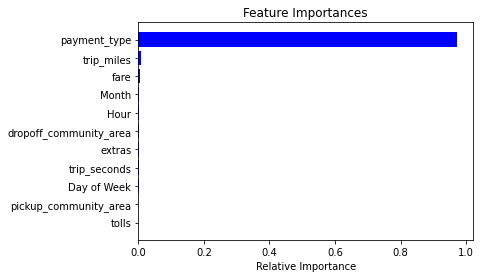

In [82]:
import matplotlib.pyplot as plt
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [Features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Payment type is most important predictor

# Save model

In [83]:
from google.colab import drive
 
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [84]:
import joblib

In [85]:
# Save the model to Drive

joblib.dump(GBmodel,'/content/drive/MyDrive/Projects/Streamlit/Classification_BigQuery/GBmodel.joblib')

['/content/drive/MyDrive/Projects/Streamlit/Classification_BigQuery/GBmodel.joblib']

# Load model

In [86]:
from google.colab import drive
 
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [87]:
import joblib
import pandas as pd

In [88]:
# Load the model
loaded_GB = joblib.load('/content/drive/MyDrive/Projects/Streamlit/Classification_BigQuery/GBmodel.joblib')

In [89]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [90]:
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [91]:
project_id = 'sixth-flag-316719'

In [92]:
from google.cloud import bigquery
 
client = bigquery.Client(project=project_id)

In [93]:
# Create an evaluation table to predict tips for 2019 Jan-Mar
 
sample_count = 40000
row_count = client.query('''
  SELECT
    COUNT(*) as total
  FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`''').to_dataframe().total[0]
 
evaluation_table = client.query('''
SELECT *
    FROM
          `bigquery-public-data.chicago_taxi_trips.taxi_trips`
    WHERE
           tips IS NOT NULL AND
           trip_seconds IS NOT NULL AND
           trip_miles IS NOT NULL AND
           fare IS NOT NULL AND
           tolls IS NOT NULL AND
           pickup_community_area IS NOT NULL AND
           dropoff_community_area IS NOT NULL AND
           trip_miles > 1 AND
           trip_seconds > 180 AND
           EXTRACT (YEAR FROM trip_start_timestamp) = 2019 AND
           (EXTRACT (MONTH FROM trip_start_timestamp) >=1 AND EXTRACT (MONTH FROM trip_start_timestamp)<=3)
           AND RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()
 
# drop unnecessary features
 
evaluation_table = evaluation_table.drop(['unique_key', 'taxi_id', 'pickup_location', 'dropoff_location', 'pickup_census_tract', 'dropoff_census_tract', 'company'], axis=1)
 
# Pre-process dates and time

evaluation_table['Month'] = evaluation_table['trip_start_timestamp'].apply(lambda time: time.month)
evaluation_table['Day of Week'] = evaluation_table['trip_start_timestamp'].apply( lambda time: time.dayofweek)
evaluation_table['Hour'] = evaluation_table['trip_start_timestamp'].apply(lambda time: time.hour)

# Since the data consists of start time and duration, start and end time stamps can be dropped
 
evaluation_table = evaluation_table.drop(['trip_start_timestamp', 'trip_end_timestamp'], axis=1)
 
# Since we have the pickup and drop communities we shouldn't need the longitudes or latitudes
 
evaluation_table = evaluation_table.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1)
 
# Drop column tips and trip total. Trip total includes the value of the variable to predict. This model only predicts if the tip value will be present. 
evaluation_table = evaluation_table.drop(['tips', 'trip_total'], axis=1)
 
evaluation_table['payment_type'] = evaluation_table['payment_type'].map({'Credit Card':0, 'Cash':1, 'Mobile':2, 'Prcard':3, 'Pcard':3, 'No Charge':4, 'Unknown':5, 'Dispute': 5, 'Split': 5})
 
evaluation_table.dropna(inplace=True)

In [94]:
evaluation_table.columns

Index(['trip_seconds', 'trip_miles', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'tolls', 'extras', 'payment_type',
       'Month', 'Day of Week', 'Hour'],
      dtype='object')

In [95]:
import numpy as np

importances = loaded_GB.feature_importances_

indices = np.argsort(importances)

In [96]:
Features = evaluation_table.columns

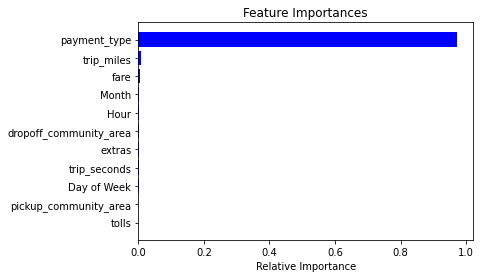

In [97]:
import matplotlib.pyplot as plt
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [Features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Payment type is most important predictor

In [98]:
predictions = loaded_GB.predict(evaluation_table)
predictions = pd.DataFrame(predictions)

In [99]:
evaluation_table['prediction'] = predictions

In [100]:
evaluation_table.head(15)

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tolls,extras,payment_type,Month,Day of Week,Hour,prediction
0,469,1.50,8,32,7.50,0.0,0.0,1,3,3,7,0
1,1067,3.85,24,21,13.50,0.0,2.0,1,3,6,3,0
2,540,2.10,32,8,8.75,0.0,1.0,0,3,4,23,1
3,660,3.20,8,28,11.25,0.0,1.0,0,3,6,3,1
4,1980,13.60,77,76,35.50,0.0,1.0,1,3,3,6,0
5,1380,3.60,33,8,14.75,0.0,1.0,1,3,3,18,0
6,720,2.00,28,8,9.50,0.0,1.0,1,3,6,15,0
7,360,1.10,32,32,6.25,0.0,1.5,1,3,5,12,0
8,360,1.80,24,32,8.25,0.0,0.0,1,3,0,6,0
9,840,1.50,28,8,9.25,0.0,0.0,0,3,2,18,1


# EDA Dashboard with Dash

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

In [101]:
import plotly.express as px
import plotly.graph_objects as go
 
dmap = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
mmap = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'July', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
evaluation_table.sort_values('Day of Week', inplace=True)
evaluation_table['Day of Week'] = evaluation_table['Day of Week'].map(dmap)
evaluation_table['Month'] = evaluation_table['Month'].map(mmap)

In [102]:
# Stacked histogram showing fare based on the tip prediction column
fig1 = go.Figure()
fig1.add_trace(go.Histogram(x=evaluation_table[evaluation_table['prediction']==1]['fare'], name="fare with predicted tip"))
fig1.add_trace(go.Histogram(x=evaluation_table[evaluation_table['prediction']==0]['fare'], name="fare with no predicted tip"))
fig1.update_layout(barmode='overlay', title='Stacked histogram showing fare based on if a tip is predicted', xaxis_title='fare') # Overlay histograms
fig1.update_traces(opacity=0.65) # Reduce opacity to see all histograms
 
# Scatterplot of trip_seconds versus fare where the points are colored by the tip prediction
fig2 = px.scatter(evaluation_table, x='trip_seconds', y='fare', color='prediction')
fig2.update_layout(title='Scatterplot of trip_seconds versus fare')
 
# Bar graph of average trip length by week day
fig3 = go.Figure()
fig3.add_trace(go.Bar(x=evaluation_table['Day of Week'].unique(), y=evaluation_table.groupby('Day of Week')['trip_miles'].mean(), name="Average trip length by week day"))
fig3.update_layout(title='Mean trip length by week day', xaxis_title='Week Day')
 
# Scatterplot of trip seconds versus miles where the points are colored by tip prediction
fig4 = px.scatter(evaluation_table, x='trip_seconds', y='trip_miles', color='prediction')
fig4.update_layout(title='Scatterplot of trip_seconds versus miles')
 
# Bar graph showing count of tip predictions per day of week
fig5 = go.Figure()
fig5.add_trace(go.Bar(x=evaluation_table['Day of Week'].unique(), y=evaluation_table[evaluation_table['prediction']==1].groupby('Day of Week')['prediction'].count(), name="Count of tips prediction by week day"))
fig5.add_trace(go.Bar(x=evaluation_table['Day of Week'].unique(), y=evaluation_table[evaluation_table['prediction']==0].groupby('Day of Week')['prediction'].count(), name="Count of tips not predicted by week day"))
fig5.update_layout(title='Count of tips predicted by week day', xaxis_title='Day')
 
# Bar graph showing count of trips by day of week
fig6 = go.Figure()
fig6.add_trace(go.Bar(x=evaluation_table['Day of Week'].unique(), y=evaluation_table.groupby('Day of Week')['trip_miles'].count(), name="Count of trips by week day"))
fig6.update_layout(title='Count of trips by week day', xaxis_title='Day')

# Stacked histogram showing payment type count based on the prediction column
fig7 = go.Figure()
fig7.add_trace(go.Histogram(x=evaluation_table[evaluation_table['prediction']==1]['payment_type'], name="payment type with tip predicted"))
fig7.add_trace(go.Histogram(x=evaluation_table[evaluation_table['prediction']==0]['payment_type'], name="payment type with no tip predicted"))
fig7.update_layout(title='Stacked histogram showing payment type based on if a tip is predicted', xaxis_title='payment type')

In [103]:
# Dashboard with Dash
 
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig1),
    dcc.Graph(figure=fig2),
    dcc.Graph(figure=fig3),
    dcc.Graph(figure=fig4),
    dcc.Graph(figure=fig5),
    dcc.Graph(figure=fig6),
    dcc.Graph(figure=fig7),
    dash_table.DataTable(
        id='table',
        columns=[{"name": i, "id": i} 
                 for i in evaluation_table.columns],
        data=evaluation_table.to_dict('records'),
        style_cell=dict(textAlign='left'),
        style_header=dict(backgroundColor="paleturquoise"),
        style_data=dict(backgroundColor="lavender")
    )
])
 
app.run_server(mode='external')

Dash app running on:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning:


The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`



<IPython.core.display.Javascript object>

In [ ]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
public_url = ngrok.connect(addr = '8050')

In [ ]:
#ngrok url link
 
public_url

<NgrokTunnel: "http://becd-34-125-159-33.ngrok.io" -> "http://localhost:8050">

In [ ]:
ngrok.kill()

# Streamlit Model Deployment link
https://share.streamlit.io/taylorec/classification_bigquery/main/Classification_BQ.py